# Variational Autoencoder



## IMPORT

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import random
import cv2
import keras

from collections import Counter  # Import Counter at the top
from keras import layers
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

## LOAD DATA

In [39]:
# Path to the extracted dataset
extracted_path = 'Desktop/CV/milestone_2'

# Maximum number of classes to use
max_classes = 100

# Function to load images and labels
def load_casia_webface_data(dataset_path, max_classes=max_classes):
    images = []
    labels = []
    label_map = {}
    current_label = 0

    # Walk through dataset directories
    for subdir, dirs, _ in os.walk(dataset_path):
        for dir_name in sorted(dirs):  # Sorting for consistency
            if current_label >= max_classes:
                break  # Stop after reaching max_classes

            identity_dir = os.path.join(subdir, dir_name)
            label_map[current_label] = dir_name  # Map label to identity
            # print(f"Processing identity: {dir_name} (Label {current_label})")

            # Process all images in the identity's folder
            for img_file in os.listdir(identity_dir):
                img_path = os.path.join(identity_dir, img_file)

                # Skip non-image files
                if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    continue

                # Load and preprocess the image
                img = cv2.imread(img_path)
                if img is None:
                    # print(f"Warning: Unable to read image {img_path}")
                    continue

                img = cv2.resize(img, (64, 64))  # Resize to 64x64 (or the desired size)
                images.append(img)
                labels.append(current_label)

            current_label += 1

        if current_label >= max_classes:
            break

    if not images:
        raise ValueError("No images were loaded. Please check the dataset structure and image paths.")

    # Convert lists to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    return images, labels, label_map

# Load dataset
try:
    images, labels, label_map = load_casia_webface_data(extracted_path, max_classes=max_classes)
    print(f"Loaded {images.shape[0]} images with {len(label_map)} identities.")
except ValueError as e:
    print(f"Error: {e}")


Loaded 14650 images with 100 identities.


## Normalize the features by subtracting the mean and dividing by the standard deviation for each channel


In [41]:
mean = np.mean(images, axis=(0, 1, 2), keepdims=True)
std = np.std(images, axis=(0, 1, 2), keepdims=True)

normalized_features = (images - mean) / std

## Adjustable function to visualize images

In [165]:
def display_images_with_labels(images, labels, predictions=None, num_samples=5, title="Sample Data Visualization"):
    # Ensure valid number of samples
    num_samples = min(num_samples, len(images))
    
    # Create a figure for visualization
    rows = 2 if predictions is not None else 1  # Add a row for predictions if available
    fig, axes = plt.subplots(rows, num_samples, figsize=(15, rows * 3))
    
    # If there's only one row, axes is a 1D array
    if rows == 1:
        axes = np.expand_dims(axes, axis=0)  # Convert to 2D array (1 row, num_samples columns)
    
    # Generate random indices for the images
    random_indices = random.sample(range(len(images)), num_samples)
    
    for i, idx in enumerate(random_indices):
        # Display the original image
        ax = axes[0, i]  # Always access the first row (original images)
        ax.imshow(images[idx].astype("uint8"))
        ax.set_title(f"True: {labels[idx]}")
        ax.axis('off')
        
        # Display the predicted label, if available
        if predictions is not None:
            pred = predictions[idx]
            axes[1, i].imshow(images[idx].astype("uint8"))
            axes[1, i].set_title(f"Pred: {pred}")
            axes[1, i].axis('off')

    # Set the title for the whole plot
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


## Display images with a global title and normalization 

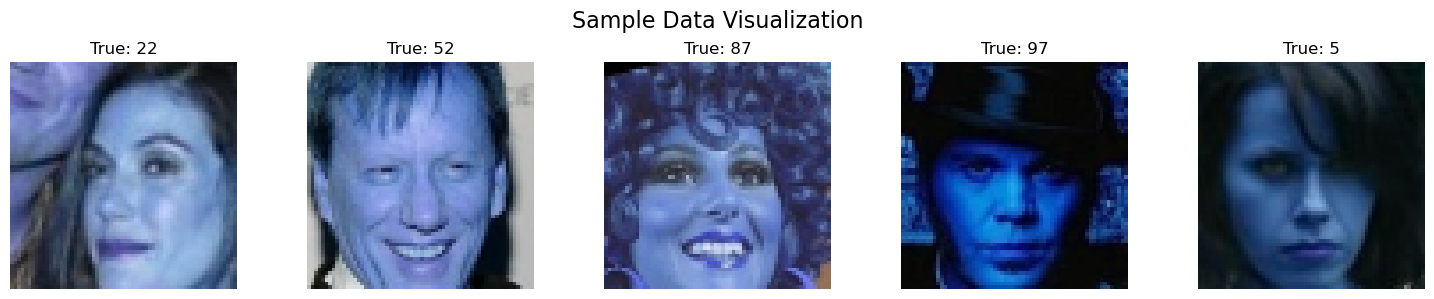

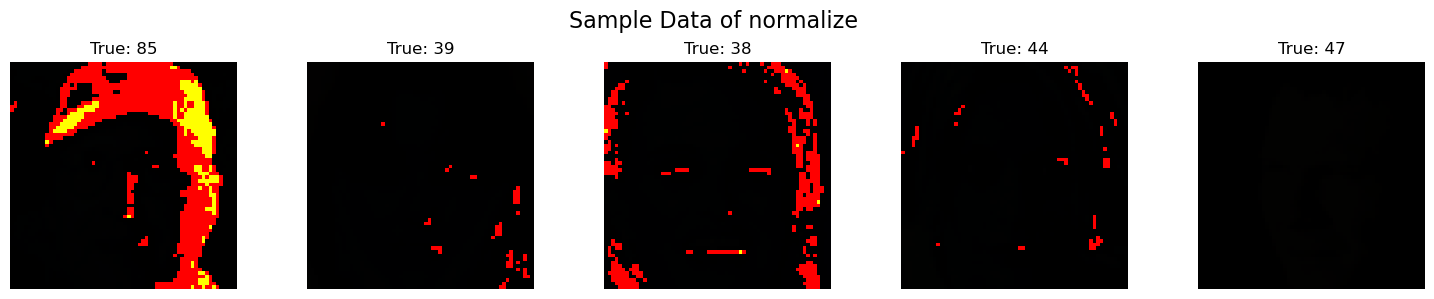

In [133]:
# Display images with a global title
display_images_with_labels(images, labels, num_samples=5, title="Sample Data Visualization")
display_images_with_labels(normalized_features, labels, num_samples=5, title="Sample Data of normalize ")

## SPLIT DATA

In [46]:

# Split the data into train and test sets (70% training, 30% testing + validation)
X_train, X_temp, y_train, y_temp = train_test_split(normalized_features, labels, test_size=0.3, random_state=123, stratify=labels)

# Split the temp data into validation and test sets (50% validation, 50% test of the 30% left)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)

## Check the shapes of the splits

In [116]:
print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Validation set size: {X_val.shape}, {y_val.shape}")
print(f"Test set size: {X_test.shape}, {y_test.shape}")

Training set size: (10255, 64, 64, 3), (10255,)
Validation set size: (2197, 64, 64, 3), (2197,)
Test set size: (2198, 64, 64, 3), (2198,)


## ENCODER DECODER(before CV)

In [51]:
latent_dim = 64  # Latent space dimension

# Encoder
input_img = tf.keras.Input(shape=(64, 64, 3), name="encoder_input")
x = tf.keras.layers.Flatten()(input_img)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = tf.keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(latent_inputs)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)
decoded = tf.keras.layers.Reshape((64, 64, 3))(x)
decoder = tf.keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 12288)     │          0 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1024)      │ 12,583,936 │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 512)       │    524,800 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     32,832 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     32,832 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,174,400 (50.26 MB)

 Trainable params: 13,174,400 (50.26 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12288)          │    12,595,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,153,792 (50.18 MB)

 Trainable params: 13,153,792 (50.18 MB)

 Non-trainable params: 0 (0.00 B)

## APLLY CROSS VALIDATION

In [214]:

# Define the latent space dimension
latent_dim = 128  # Latent space dimension

# Function to build VAE model dynamically based on layer configurations
def build_vae(encoder_layers, decoder_layers):
    # Encoder
    input_img = tf.keras.Input(shape=(64, 64, 3), name="encoder_input")
    x = tf.keras.layers.Flatten()(input_img)
    for units in encoder_layers:
        x = tf.keras.layers.Dense(units, activation='relu', kernel_initializer='he_normal')(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

    # Reparameterization trick
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
        return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

    z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder = tf.keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
    x = latent_inputs
    for units in decoder_layers:
        x = tf.keras.layers.Dense(units, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)
    decoded = tf.keras.layers.Reshape((64, 64, 3))(x)
    decoder = tf.keras.Model(latent_inputs, decoded, name="decoder")

    # VAE Model with custom loss
    class VAE(tf.keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        def call(self, inputs):
            z_mean, z_log_var, z = self.encoder(inputs)
            reconstructed = self.decoder(z)
            self.add_loss(self.vae_loss(inputs, reconstructed, z_mean, z_log_var))  # Add the loss here
            return reconstructed
        
        def vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
            # Reconstruction loss (mean squared error)
            reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
            
            # KL divergence loss
            kl_loss = - 0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
            )
            
            return reconstruction_loss + kl_loss

    return VAE(encoder, decoder)

# Define layer combinations
layer_combinations = [
    # {'encoder': [128], 'decoder': [128]},
    # {'encoder': [256], 'decoder': [256]},
    {'encoder': [256, 128], 'decoder': [128, 256]},
    {'encoder': [1024, 512], 'decoder': [512, 1024]},
    {'encoder': [2048, 1024], 'decoder': [1024, 2048]},
    # Add more layer combinations as needed
]

# Example dataset (replace with your actual data)
X = np.random.rand(10255, 64, 64, 3)  # Example: 10255 images of 64x64 with 3 channels

# Hyperparameters
num_folds = 5
sample_fraction = 0.1  # Use 10% of the training set in each fold

# Cross-validation setup
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
results = {}

for layer_config in layer_combinations:
    encoder_layers = layer_config['encoder']
    decoder_layers = layer_config['decoder']
    
    print(f"Testing Configuration: Encoder {encoder_layers}, Decoder {decoder_layers}")
    
    fold_losses = []
    for train_idx, val_idx in kfold.split(X):
        # Split dataset
        X_train, X_val = X[train_idx], X[val_idx]
        
        # Take a random sample of the training data (10%)
        train_sample_size = int(len(X_train) * sample_fraction)
        sampled_indices = np.random.choice(len(X_train), train_sample_size, replace=False)
        X_train_sampled = X_train[sampled_indices]
        
        # Build the VAE model for each fold
        vae = build_vae(encoder_layers, decoder_layers)
        
        # Compile the model
        vae.compile(optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
        
        # Train the model
        history = vae.fit(
            X_train_sampled, X_train_sampled,  # Input and target are the same for autoencoder
            epochs=10,
            batch_size=32,
            validation_data=(X_val, X_val),
            verbose=0
        )
        
        # Record the validation loss for the fold
        val_loss = history.history['val_loss'][-1]
        fold_losses.append(val_loss)

    # Compute the average validation loss for the configuration
    avg_val_loss = np.mean(fold_losses)
    results[str(layer_config)] = avg_val_loss
    print(f"Average Validation Loss for Configuration {layer_config}: {avg_val_loss}")

# Find the best configuration based on the lowest validation loss
best_config = min(results, key=results.get)
print(f"Best Configuration: {best_config} with Loss: {results[best_config]}")


Testing Configuration: Encoder [256, 128], Decoder [128, 256]
Average Validation Loss for Configuration {'encoder': [256, 128], 'decoder': [128, 256]}: 0.08345535695552826
Testing Configuration: Encoder [1024, 512], Decoder [512, 1024]
Average Validation Loss for Configuration {'encoder': [1024, 512], 'decoder': [512, 1024]}: 0.09531943500041962
Testing Configuration: Encoder [2048, 1024], Decoder [1024, 2048]
Average Validation Loss for Configuration {'encoder': [2048, 1024], 'decoder': [1024, 2048]}: 0.6621396079659462
Best Configuration: {'encoder': [256, 128], 'decoder': [128, 256]} with Loss: 0.08345535695552826


## Nnew cross validation 

In [53]:

# Define the latent space dimension
latent_dim = 128  # Latent space dimension

# Function to build VAE model dynamically based on layer configurations
def build_vae(encoder_layers, decoder_layers):
    # Encoder
    input_img = tf.keras.Input(shape=(64, 64, 3), name="encoder_input")
    x = tf.keras.layers.Flatten()(input_img)
    for units in encoder_layers:
        x = tf.keras.layers.Dense(units, activation='relu', kernel_initializer='he_normal')(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

    # Reparameterization trick
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
        return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

    z = tf.keras.layers.Lambda(sampling, name="z")([z_mean, z_log_var])
    encoder = tf.keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
    x = latent_inputs
    for units in decoder_layers:
        x = tf.keras.layers.Dense(units, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)
    decoded = tf.keras.layers.Reshape((64, 64, 3))(x)
    decoder = tf.keras.Model(latent_inputs, decoded, name="decoder")

    # VAE Model with custom loss
    class VAE(tf.keras.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder

        def call(self, inputs):
            z_mean, z_log_var, z = self.encoder(inputs)
            reconstructed = self.decoder(z)
            self.add_loss(self.vae_loss(inputs, reconstructed, z_mean, z_log_var))  # Add the loss here
            return reconstructed
        
        def vae_loss(self, x, x_decoded_mean, z_mean, z_log_var):
            # Reconstruction loss (mean squared error)
            reconstruction_loss = tf.reduce_mean(tf.square(x - x_decoded_mean))
            
            # KL divergence loss
            kl_loss = - 0.5 * tf.reduce_mean(
                z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
            )
            
            return reconstruction_loss + kl_loss

    return VAE(encoder, decoder)

# Define layer combinations 
layer_combinations = [
    {'encoder': [128], 'decoder': [128]},
    {'encoder': [256], 'decoder': [256]},
    {'encoder': [1024, 512, 256], 'decoder': [256, 512, 1024]},  
    {'encoder': [512, 256, 128], 'decoder': [128, 256, 512]},    
    {'encoder': [2048, 1024, 512], 'decoder': [512, 1024, 2048]}
]


# Example dataset (replace with your actual data)
X = np.random.rand(10255, 64, 64, 3)  # Example: 10255 images of 64x64 with 3 channels

# Hyperparameters
num_folds = 5
sample_fraction = 0.1  # Use 10% of the training set in each fold

# Cross-validation setup
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
results = {}

for layer_config in layer_combinations:
    encoder_layers = layer_config['encoder']
    decoder_layers = layer_config['decoder']
    
    print(f"Testing Configuration: Encoder {encoder_layers}, Decoder {decoder_layers}")
    
    fold_losses = []
    for train_idx, val_idx in kfold.split(X):
        # Split dataset
        X_train, X_val = X[train_idx], X[val_idx]
        
        # Take a random sample of the training data (10%)
        train_sample_size = int(len(X_train) * sample_fraction)
        sampled_indices = np.random.choice(len(X_train), train_sample_size, replace=False)
        X_train_sampled = X_train[sampled_indices]
        
        # Build the VAE model for each fold
        vae = build_vae(encoder_layers, decoder_layers)
        
        # Compile the model
        vae.compile(optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
        
        # Train the model
        history = vae.fit(
            X_train_sampled, X_train_sampled,  # Input and target are the same for autoencoder
            epochs=10,
            batch_size=32,
            validation_data=(X_val, X_val),
            verbose=0
        )
        
        # Record the validation loss for the fold
        val_loss = history.history['val_loss'][-1]
        fold_losses.append(val_loss)

    # Compute the average validation loss for the configuration
    avg_val_loss = np.mean(fold_losses)
    results[str(layer_config)] = avg_val_loss
    print(f"Average Validation Loss for Configuration {layer_config}: {avg_val_loss}")

# Find the best configuration based on the lowest validation loss
best_config = min(results, key=results.get)
print(f"Best Configuration: {best_config} with Loss: {results[best_config]}")


Testing Configuration: Encoder [128], Decoder [128]
Average Validation Loss for Configuration {'encoder': [128], 'decoder': [128]}: 0.08375960886478424
Testing Configuration: Encoder [256], Decoder [256]
Average Validation Loss for Configuration {'encoder': [256], 'decoder': [256]}: 0.0842845156788826
Testing Configuration: Encoder [1024, 512, 256], Decoder [256, 512, 1024]
Average Validation Loss for Configuration {'encoder': [1024, 512, 256], 'decoder': [256, 512, 1024]}: 0.08441147059202195
Testing Configuration: Encoder [512, 256, 128], Decoder [128, 256, 512]
Average Validation Loss for Configuration {'encoder': [512, 256, 128], 'decoder': [128, 256, 512]}: 0.08339771777391433
Testing Configuration: Encoder [2048, 1024, 512], Decoder [512, 1024, 2048]
Average Validation Loss for Configuration {'encoder': [2048, 1024, 512], 'decoder': [512, 1024, 2048]}: 0.08612627238035202
Best Configuration: {'encoder': [512, 256, 128], 'decoder': [128, 256, 512]} with Loss: 0.08339771777391433


## resplit

In [57]:

# Split the data into train and test sets (70% training, 30% testing + validation)
X_train, X_temp, y_train, y_temp = train_test_split(normalized_features, labels, test_size=0.3, random_state=123, stratify=labels)

# Split the temp data into validation and test sets (50% validation, 50% test of the 30% left)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)

## ENCODER DECODER(After CV)

In [59]:
latent_dim = 64  # Latent space dimension

# Encoder
input_img = tf.keras.Input(shape=(64, 64, 3), name="encoder_input")
x = tf.keras.layers.Flatten()(input_img)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

# Reparameterization trick
# this sampling layer is the bottleneck layer of variational autoencoder,
# it uses the output from two dense layers z_mean and z_log_var as input, 
# convert them into normal distribution and pass them to the decoder layer

class Sampling(layers.Layer):
	"""Uses (mean, log_var) to sample z, the vector encoding a digit."""

	def call(self, inputs):
		mean, log_var = inputs
		batch = tf.shape(mean)[0]
		dim = tf.shape(mean)[1]
		epsilon = tf.random.normal(shape=(batch, dim))
		return mean + tf.exp(0.5 * log_var) * epsilon


z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(input_img, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal')(latent_inputs)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(64 * 64 * 3, activation='sigmoid')(x)
decoded = tf.keras.layers.Reshape((64, 64, 3))(x)
decoder = tf.keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_35          │ (None, 12288)     │          0 │ encoder_input[0]… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_153 (Dense)   │ (None, 1024)      │ 12,583,936 │ flatten_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_154 (Dense)   │ (None, 512)       │    524,800 │ dense_153[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     32,832 │ dense_154[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     32,832 │ dense_154[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,174,400 (50.26 MB)

 Trainable params: 13,174,400 (50.26 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 12288)          │    12,595,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_29 (Reshape)            │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,153,792 (50.18 MB)

 Trainable params: 13,153,792 (50.18 MB)

 Non-trainable params: 0 (0.00 B)

## VAE Model


## Define VAE loss


In [61]:
class VAELossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        input_img, decoded, z_mean, z_log_var = inputs

        # Flatten images for loss computation
        input_flat = tf.keras.layers.Flatten()(input_img)
        decoded_flat = tf.keras.layers.Flatten()(decoded)

        # Reconstruction loss (Mean Squared Error)
        reconstruction_loss = tf.reduce_mean(tf.square(input_flat - decoded_flat), axis=-1)

        # KL divergence loss (with small epsilon to avoid instability)
        kl_weight = 0.001  # Scale the KL loss term to avoid instability
        kl_loss = kl_weight * (-0.001 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1
        ))

        # Total loss (reconstruction loss + KL divergence)
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)

        return decoded  # Return decoded images to maintain the architecture

    def compute_output_shape(self, input_shape):
        return input_shape[1]  # Output shape should match the decoded images' shape


## VAE model

In [63]:
# VAE model
vae_outputs = decoder(encoder(input_img)[2])  # Use the z (latent space) from encoder
vae_outputs = VAELossLayer()([input_img, vae_outputs, z_mean, z_log_var])  # Add custom loss layer
vae = Model(input_img, vae_outputs, name="vae")
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0), metrics=['accuracy'])

# Reshape the data
X_train_reshaped = X_train.reshape(-1, 64, 64, 3)
X_val_reshaped = X_val.reshape(-1, 64, 64, 3)

# Train the VAE
history = vae.fit(
    X_train_reshaped, X_train_reshaped,  # Pass both input and target as the same image data
    epochs=10,
    batch_size=32,
    validation_data=(X_val_reshaped, X_val_reshaped)  # Pass validation data as input data
)

Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - accuracy: 0.6075 - loss: 19.0344 - val_accuracy: 0.6967 - val_loss: 14.0617
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 81s 253ms/step - accuracy: 0.7253 - loss: 13.6345 - val_accuracy: 0.7433 - val_loss: 13.3814
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 81s 252ms/step - accuracy: 0.7490 - loss: 13.1948 - val_accuracy: 0.7532 - val_loss: 13.0231
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 82s 256ms/step - accuracy: 0.7631 - loss: 12.7976 - val_accuracy: 0.7603 - val_loss: 12.8428
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 80s 251ms/step - accuracy: 0.7751 - loss: 12.8439 - val_accuracy: 0.7758 - val_loss: 12.6788
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 81s 251ms/step - accuracy: 0.7824 - loss: 12.4549 - val_accuracy: 0.7800 - val_loss: 12.5592
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 81s 253ms/step - accuracy: 0.7878 - loss: 12.4208 - val_accuracy: 0.7826 - val_loss: 12.4873
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 82s 254ms/step - accuracy: 0.

## Compile the VAE


In [66]:
# Encode the features
encoded_features_train = encoder.predict(X_train)[0]
encoded_features_val = encoder.predict(X_val)[0]
encoded_features_test = encoder.predict(X_test)[0]


321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


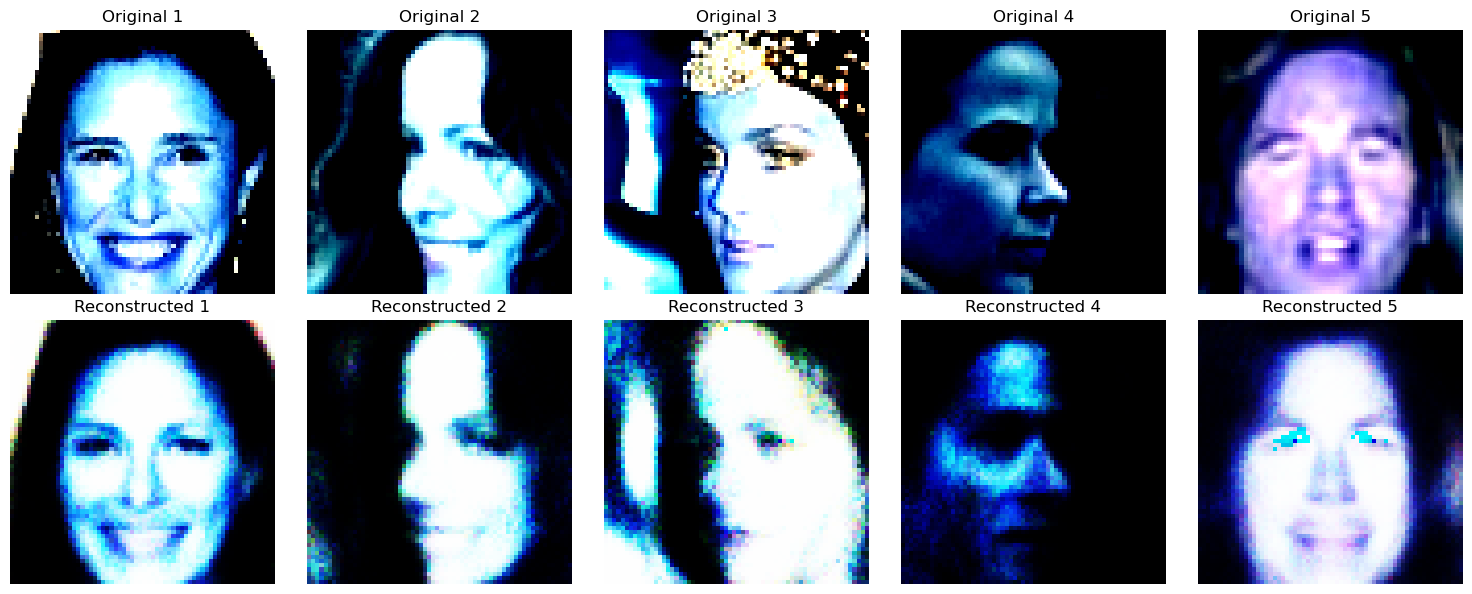

In [141]:
import numpy as np
import matplotlib.pyplot as plt

# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = np.random.randint(0, X_train_reshaped.shape[0], num_samples)

# Create a figure for displaying images
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

for i, idx in enumerate(random_indices):
    # Get the original image
    original_image = X_train_reshaped[idx]

    # Get the latent space encoding (z) for the original image
    encoded_features = encoder.predict(np.expand_dims(original_image, axis=0))[2]

    # Reconstruct the image using the decoder
    reconstructed_image = decoder.predict(encoded_features)

    # Normalize the images to the range [0, 1]
    original_image = np.clip(original_image, 0, 1)
    reconstructed_image = np.clip(reconstructed_image[0], 0, 1)

    # Display the original image
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"Original {i+1}")
    axes[0, i].axis('off')

    # Display the reconstructed image
    axes[1, i].imshow(reconstructed_image)
    axes[1, i].set_title(f"Reconstructed {i+1}")
    axes[1, i].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## VIsualization

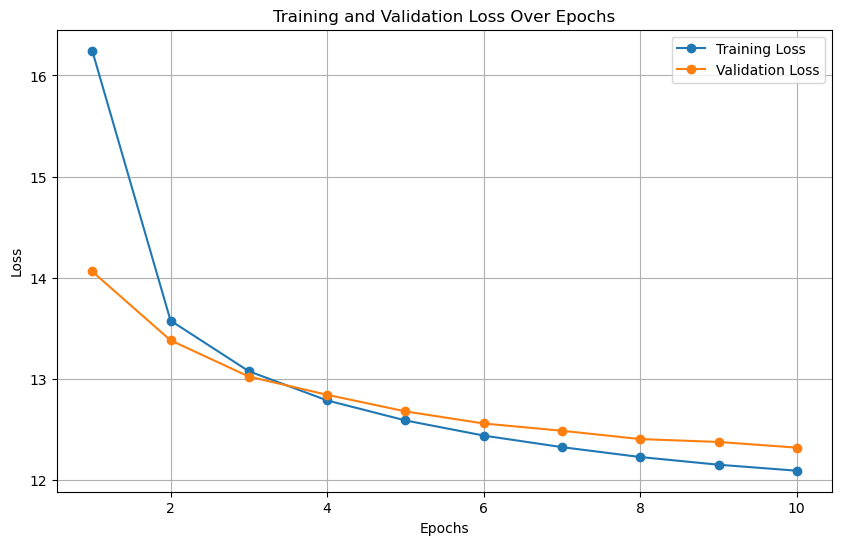

In [76]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Own implementation of the KNN algorithm

In [78]:
def euclidean_distance(x1, x2):
    distance = np.sqrt(np.sum((x1-x2)**2))
    return distance

class the_minimum_Euclidean_distance_classifier:
    def __init__(self, k=3): #we make default 3 the votes might be 2:1, ensuring a clear winner smaller than will be no winner or overfitting
        self.k = k

    def fit(self, X, y): #fit means stores our trainnig set
        self.X_train = X    
        self.y_train = y

    def _predict(self, x):
        # compute the distance
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train] #x is the test set from xtrain to last value in x_train 
    
        # get the closest k
        k_indices_feature = np.argsort(distances)[:self.k] ## sorting ascending order to find the nearest point and determine which class belongs
        k_nearest_labels = [self.y_train[i] for i in k_indices_feature]

        # majority voye
        most_common = Counter(k_nearest_labels).most_common()  ## to count the occurrences of each element in an iterable (like a list).
        return most_common[0][0]  ##first element in first label
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions

## KNN classifier built with a manually implemented KNN algorithm

In [33]:
classifier = the_minimum_Euclidean_distance_classifier(k=1)
classifier.fit(encoded_features_train, y_train)
y_pred = classifier.predict(encoded_features_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Recognition Accuracy: {accuracy * 100:.2f}%")  

Recognition Accuracy: 31.94%


## KNN classifier using the scikit-learn library

In [150]:
# Train the classifier on the encoded features of the training set
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(encoded_features_test)

# Evaluate the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Recognition Accuracy: {accuracy * 100:.2f}%")

Recognition Accuracy: 31.80%


## Display a random image from the test set along with its true and predicted labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


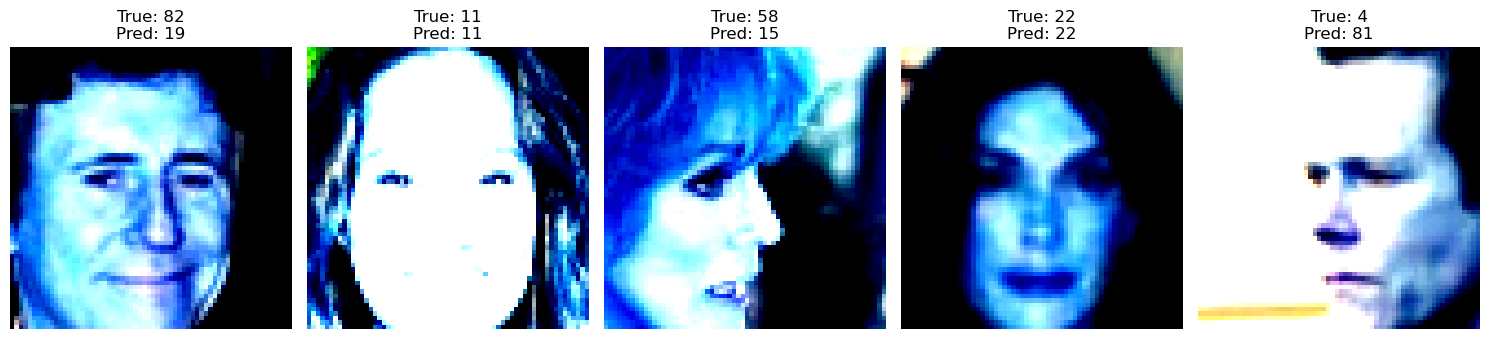

In [187]:
# Number of random samples to display
num_samples = 5

# Generate random indices for the samples
random_indices = np.random.randint(0, len(X_test), num_samples)

# Create a figure for displaying images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

# Ensure axes is iterable even if there's only one axis
if num_samples == 1:
    axes = [axes]

for i, idx in enumerate(random_indices):
    # Get the test image and its true label
    test_image = X_test[idx]
    true_label = y_test[idx]
    
    # Check if the image is normalized (values between 0 and 1)
    if test_image.max() <= 1:  # Likely normalized, rescale to 0-255 range
        test_image = (test_image * 255).astype(np.uint8)

    # Clip the image values to the valid range [0, 255]
    test_image = np.clip(test_image, 0, 255)

    # Get the predicted label (KNN is already giving the predicted label)
    predicted_label = knn.predict([encoded_features_test[idx]])[0]
    
    # Display the image
    if len(test_image.shape) == 2:  # Grayscale image
        axes[i].imshow(test_image, cmap='gray')
    else:  # RGB image
        axes[i].imshow(test_image)

    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')  # Hide axes for better visualization

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
